# Deep dive Airbnb Listings in Chicago - Yunzhi Wang

Inside Airbnb utilizes public information compiled from the Airbnb web-site and analyzes publicly available information about a city's Airbnb's listings, and provides filters and key metrics so we can see how Airbnb is being used in the major cities around the world. This time, I used the listings, calendar and review data from this website to explore the airbnb listings in Chicago.

## Calendar

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# reviews = pd.read_csv('reviews.csv.gz')
# calendar = pd.read_csv('calendar.csv.gz')
# listings = pd.read_csv('listings.csv.gz')

In [4]:
calendar = pd.read_csv('calendar.csv')
print('We have', calendar.date.nunique(), 'days and', calendar.listing_id.nunique(), 'unique listings in the calendar data.')

We have 365 days and 7594 unique listings in the calendar data.


In [5]:
calendar.date.min(), calendar.date.max()

('2018-11-15', '2019-11-14')

The calendar covers one year time frame, that is, price and availability every day for the next one year, from 2018–11–15 to 2019–11–14.

### Availability on the Calendar

When we look at calendar data, we may wonder: how busy will it be for Airbnb hosts in Chicago for the next year?

In [6]:
calendar.available.value_counts()

f    1482887
t    1288923
Name: available, dtype: int64

f(false) means not available, t(true) means available. To find out daily average availability for one year, we will convert available column to 0 if available and 1 if not.

/Users/yzw/anaconda/envs/p36workshop/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


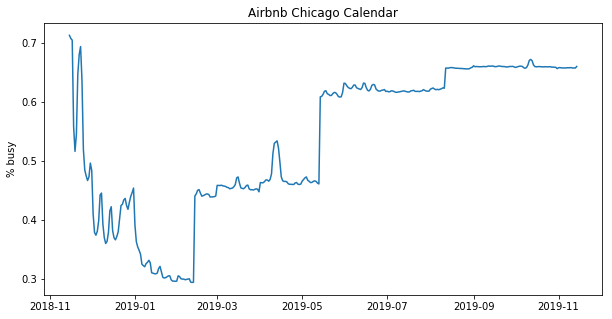

In [7]:
calendar_new = calendar[['date', 'available']]
calendar_new['busy'] = calendar_new.available.map( lambda x: 0 if x == 't' else 1)
calendar_new = calendar_new.groupby('date')['busy'].mean().reset_index()
calendar_new['date'] = pd.to_datetime(calendar_new['date'])
plt.figure(figsize=(10, 5))
plt.plot(calendar_new['date'], calendar_new['busy'])
plt.title('Airbnb Chicago Calendar')
plt.ylabel('% busy')
plt.show();

The busiest month in Chicago was November which has just passed.The next busy months seems after May and extend to the summer. These are all within our knowledge and expectations.

### Price on the Calendar

How price changes over the year by month?

We remove “$” symbol in price column and convert it to numeric, and convert date to datetime data type.

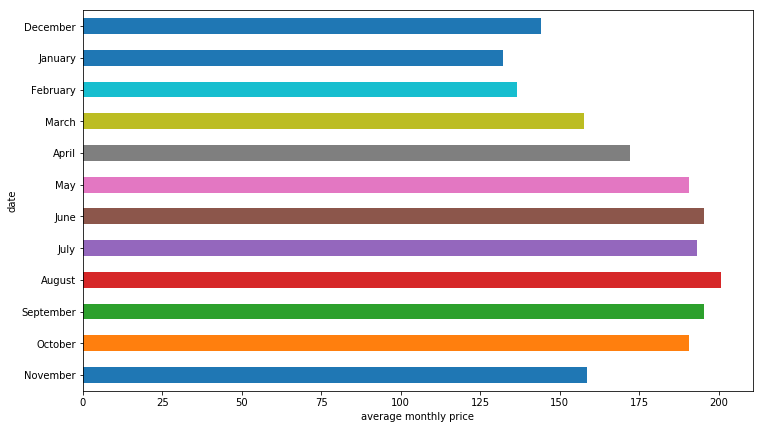

In [8]:
calendar['date'] = pd.to_datetime(calendar['date'])
calendar['price'] = calendar['price'].str.replace(',', '')
calendar['price'] = calendar['price'].str.replace('$', '')
calendar['price'] = calendar['price'].astype(float)
calendar['date'] = pd.to_datetime(calendar['date'])

mean_of_month = calendar.groupby(calendar['date'].dt.strftime('%B'),
                                 sort=False)['price'].mean()
mean_of_month.plot(kind = 'barh' , figsize = (12,7))
plt.xlabel('average monthly price');

The Airbnb price in Chicago has its peak from May to October, which are exactly the best time to visit Chicago.

How price changes during day of week?

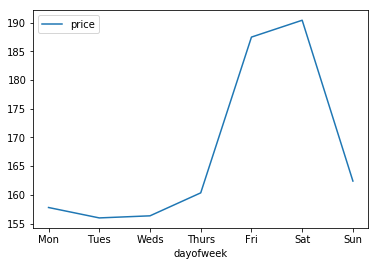

In [9]:
calendar['dayofweek'] = calendar.date.dt.weekday_name
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
price_week=calendar[['dayofweek','price']]
price_week = calendar.groupby(['dayofweek']).mean().reindex(cats)
price_week.drop('listing_id', axis=1, inplace=True)
price_week.plot()
ticks = list(range(0, 7, 1)) # points on the x axis where you want the label to appear
labels = "Mon Tues Weds Thurs Fri Sat Sun".split()
plt.xticks(ticks, labels);

Fridays and Saturdays are over $30 more expensive than the rest of the week.

## Listings

### Number of listings in each neighbourhood

In [10]:
listings = pd.read_csv('listings_big.csv')

In [11]:
cols = [
    'id',
    'host_id',
    'zipcode',
    'property_type',
    'room_type',
    'accommodates',
    'bedrooms',
    'beds',
    'bed_type',
    'price',
    'number_of_reviews',
    'review_scores_rating',
    'host_listings_count',
    'availability_30',
    'minimum_nights',
    'bathrooms',
    'amenities',
    'neighbourhood_cleansed',
    'cancellation_policy',
    'instant_bookable',
    'host_is_superhost',
    'host_identity_verified', 
    'host_has_profile_pic',
    'is_location_exact', 
    'requires_license',
    'require_guest_profile_picture', 
    'require_guest_phone_verification',
    'security_deposit', 
    'cleaning_fee',
    'host_total_listings_count',
    'guests_included'
]

In [12]:
#listings.accommodates.unique()
#listings.instant_bookable.unique()
#listings.cancellation_policy.unique()

In [13]:
listings = pd.read_csv("listings_big.csv",usecols= cols)
print('We have', listings.id.nunique(), 'listings in the listing data.')

We have 7594 listings in the listing data.


## Amenities

In [14]:
listings.amenities = listings.amenities.str.replace("[{}]", "").str.replace('"', "")

In [15]:
listings.amenities.head()

0    TV,Wifi,Kitchen,Breakfast,Free street parking,...
1    TV,Cable TV,Internet,Wifi,Air conditioning,Kit...
2    TV,Internet,Wifi,Air conditioning,Kitchen,Free...
3    TV,Cable TV,Internet,Wifi,Air conditioning,Kit...
4    TV,Cable TV,Internet,Wifi,Air conditioning,Kit...
Name: amenities, dtype: object

### Top 20 most commmon amenities

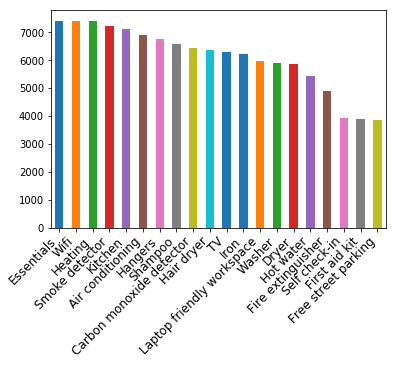

In [16]:
pd.Series(np.concatenate(listings['amenities'].map(lambda amns: amns.split(","))))\
    .value_counts().head(20)\
    .plot(kind='bar')
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
plt.show();

Essentials, wifi, heating, smoke detector and kitchen are among the most common amenities.

## Price vs Top 20 amenities

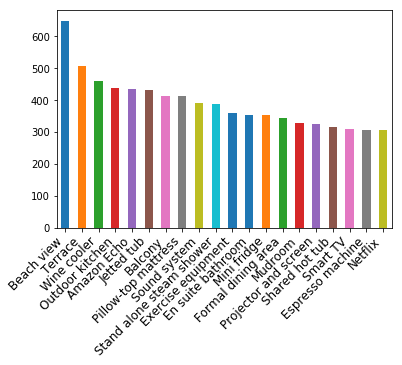

In [17]:

amenities = np.unique(np.concatenate(listings['amenities'].map(lambda amns: amns.split(","))))
#clean the price data
listings['price'] = listings['price'].str.replace(',', '')
listings['price'] = listings['price'].str.replace('$', '')
listings['price'] = listings['price'].astype(float)

amenity_prices = [(amn, listings[listings['amenities'].map(lambda amns: amn in amns)]['price'].mean()) for amn in amenities if amn != ""]
amenity_srs = pd.Series(data=[a[1] for a in amenity_prices], index=[a[0] for a in amenity_prices])

amenity_srs.sort_values(ascending=False)[:20].plot(kind='bar')
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
plt.show();



We can see clearly a relationship between higher-price homes and amenities. Beach view, terrace and wine cooler, for instance.

## Some data cleaning

1.We drop any entries that are missing (NaN) values (except for review_scores_rating).

2.We convert the format in price from $1.00 into a float of 1.00. ( Done in the amenities phase)

3.Drop any entries that are inconsistent; i.e. accommodates, bedrooms, beds, or price with a value of 0.

4.Convert ZipCode values such as 10022-4175 into 10022

In [18]:
# remove NaN values from dataframe,except for review_scores_rating
original = len(listings)
listings = listings.dropna(how='any', subset=['zipcode', 'property_type', 'bedrooms', 'beds', 'bathrooms','host_identity_verified',
                                             'host_has_profile_pic','host_total_listings_count','host_listings_count','host_is_superhost'])
print ('Number of NaN values removed:', original - len(listings))


# drop any entries that are inconsistent; i.e. predictors accommodates, bedrooms, beds, or price with a value of 0.
listings = listings[listings['accommodates'] != 0]
listings = listings[listings['bedrooms'] != 0]
listings = listings[listings['beds'] != 0]
#listings = listings[listings['price'] != 0.00]

# convert zipcodes ,Convert ZipCode values such as 60612-4175 into 60612
listings['zipcode'] = listings['zipcode'].str.replace(r'-\d+', '')

Number of NaN values removed: 33


In [19]:
listings.groupby(by='neighbourhood_cleansed').count()[['id']].sort_values(by='id', ascending=False).head(10)

,id
neighbourhood_cleansed,
West Town,972
Lake View,683
Logan Square,503
Near North Side,481
Lincoln Park,363
Near West Side,339
Uptown,255
Loop,247
Lower West Side,220


The neighbourhood that has the highest number of listings is West Town, but there is no surprise that most of the homes are located in the north side.

## Review score ratings

/Users/yzw/anaconda/envs/p36workshop/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


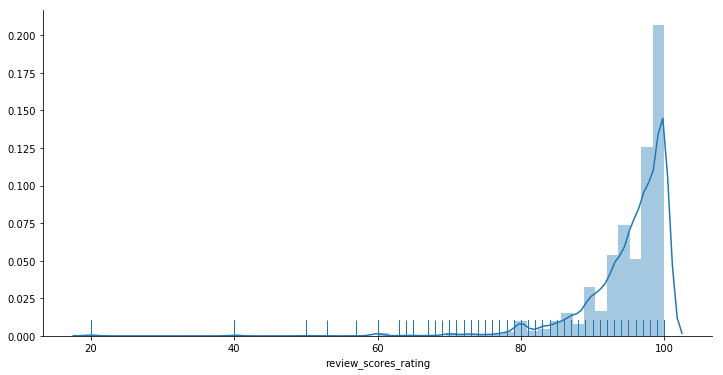

In [20]:
plt.figure(figsize=(12,6))
sns.distplot(listings.review_scores_rating.dropna(), rug=True)
sns.despine()
plt.show();

In [21]:
listings.review_scores_rating.describe()

count    6094.000000
mean       95.047424
std         6.539824
min        20.000000
25%        93.000000
50%        97.000000
75%        99.000000
max       100.000000
Name: review_scores_rating, dtype: float64

Most of the reviews have high scores, as we see that a vast majority of the listings seem to have overall favorable ratings; i.e. skewed left distribution.

## Exploring the price

The price column needs some cleaning such as remove “$” and convert to numeric.

In [22]:
listings['price'].describe()

count     6937.000000
mean       147.078276
std        240.581673
min          0.000000
25%         60.000000
50%         99.000000
75%        165.000000
max      10000.000000
Name: price, dtype: float64

The most expensive Airbnb listing in Chicago is $10000/night.


In order not to be affected by the extreme cases, we will remove listings that exceed $500/night, as well as listings at price 0.

In [23]:
listings.loc[listings['price'] > 500]['price'].describe()

count      182.000000
mean      1064.390110
std       1024.972877
min        519.000000
25%        600.000000
50%        750.000000
75%       1000.000000
max      10000.000000
Name: price, dtype: float64

In [24]:
listings.loc[listings['price'] == 0]['price'].count()

6

## Listings price distribution after removing outliers

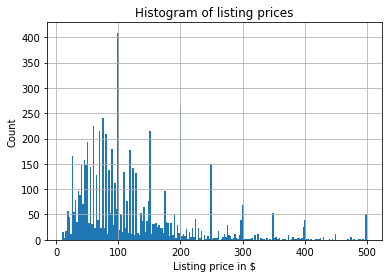

In [25]:
listings.loc[(listings.price <= 500) & (listings.price > 0)].price.hist(bins=200)
plt.ylabel('Count')
plt.xlabel('Listing price in $')
plt.title('Histogram of listing prices');


# Neighbourhood vs. Price

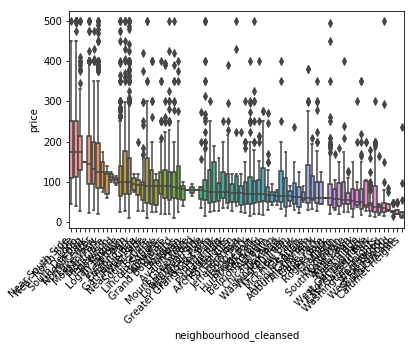

In [26]:
sort_price = listings.loc[(listings.price <= 500) & (listings.price > 0)]\
                    .groupby('neighbourhood_cleansed')['price']\
                    .median()\
                    .sort_values(ascending=False)\
                    .index
sns.boxplot(y='price', x='neighbourhood_cleansed', data=listings.loc[(listings.price <= 500) & (listings.price > 0)], 
            order=sort_price)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show();


It's interesting to find out that the near south side and the near north side has similar high price intervals.

## Cancellation Policy vs Price

In [27]:
listings.cancellation_policy.value_counts()

strict_14_with_grace_period    2755
moderate                       2404
flexible                       1753
strict                           13
super_strict_30                   8
super_strict_60                   4
Name: cancellation_policy, dtype: int64

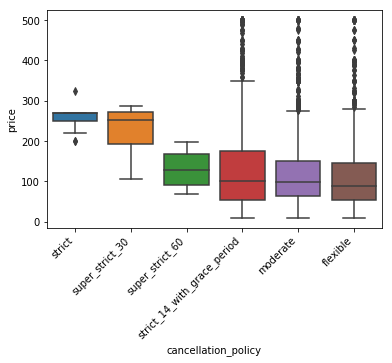

In [28]:
sort_price = listings.loc[(listings.price <= 500) & (listings.price > 0)]\
                    .groupby('cancellation_policy')['price']\
                    .median()\
                    .sort_values(ascending=False)\
                    .index
sns.boxplot(y='price', x='cancellation_policy', data=listings.loc[(listings.price <= 500) & (listings.price > 0)], order=sort_price)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show();

This makes sense. Higher-priced homes are usually associated with stricter cancellation policy.

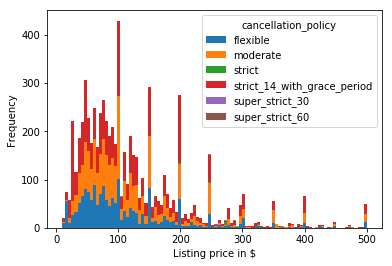

In [29]:
listings.loc[(listings.price <= 500) & (listings.price > 0)].pivot(columns = 'cancellation_policy', values = 'price').plot.hist(stacked = True, bins=100)
plt.xlabel('Listing price in $');

## Instant_bookable vs price

In [30]:
listings.instant_bookable.value_counts()

t    3501
f    3436
Name: instant_bookable, dtype: int64

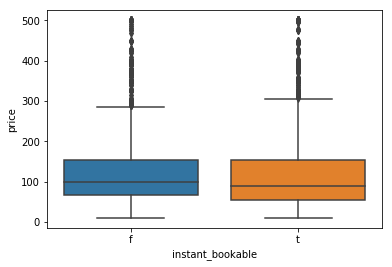

In [31]:
sns.boxplot(y='price', x='instant_bookable', data=listings.loc[(listings.price <= 500) & (listings.price > 0)])
plt.show();

Instant_bookable homes have a lower median price than not instant bookable ones. Probably because those instant_bookable homes are not that competitive

## Host vs price

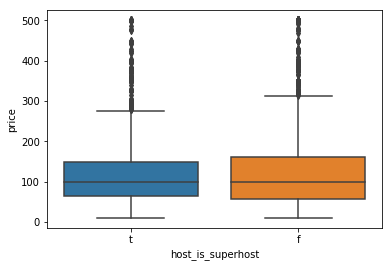

In [32]:
sns.boxplot(y='price', x='host_is_superhost', data=listings.loc[(listings.price <= 500) & (listings.price > 0)])
plt.show();

## property type vs price

In [33]:
listings.property_type.value_counts()

Apartment             3774
House                 1144
Condominium           1140
Townhouse              214
Loft                   183
Serviced apartment     132
Guest suite            110
Boutique hotel          69
Bungalow                47
Guesthouse              31
Bed and breakfast       29
Hostel                  22
Other                   15
Aparthotel               6
Cottage                  4
Boat                     3
Tiny house               3
Castle                   3
Hotel                    2
Cabin                    1
Resort                   1
Hut                      1
Farm stay                1
Cave                     1
Villa                    1
Name: property_type, dtype: int64

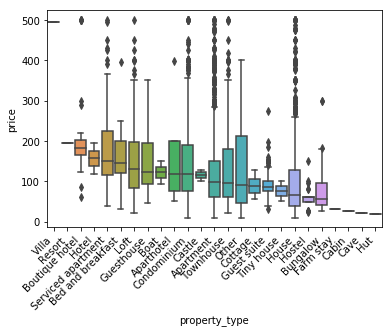

In [34]:
sort_price = listings.loc[(listings.price <= 500) & (listings.price > 0)]\
                    .groupby('property_type')['price']\
                    .median()\
                    .sort_values(ascending=False)\
                    .index
sns.boxplot(y='price', x='property_type', data=listings.loc[(listings.price <= 500) & (listings.price > 0)], order=sort_price)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show();

When we look at the median price for each property type, we should know that we can't say "The most expensive property type is villa or resort, as they have a higher median price than others", because villa and resort has only one listing each.


## room type vs. price

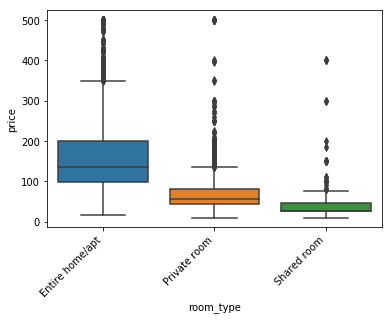

In [35]:
sort_price = listings.loc[(listings.price <= 500) & (listings.price > 0)]\
                    .groupby('room_type')['price']\
                    .median()\
                    .sort_values(ascending=False)\
                    .index
sns.boxplot(y='price', x='room_type', data=listings.loc[(listings.price <= 500) & (listings.price > 0)], order=sort_price)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show();

Entire home/apt has a a much higher median price than the other room types.

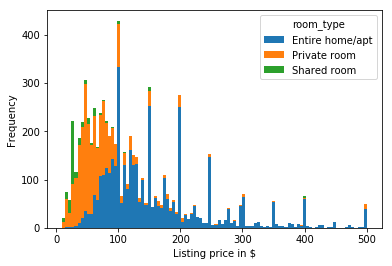

In [36]:
listings.loc[(listings.price <= 500) & (listings.price > 0)].pivot(columns = 'room_type', values = 'price').plot.hist(stacked = True, bins=100)
plt.xlabel('Listing price in $');

Entire home/apt also has the most number of listings. Inside Airbnb has indicated that Entire homes or apartments highly available year-round for tourists.

## bed type vs price

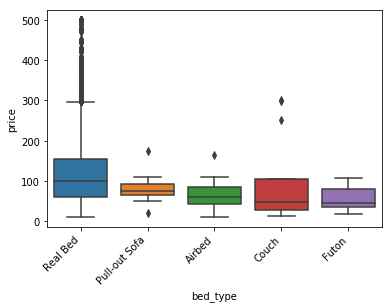

In [37]:
sort_price = listings.loc[(listings.price <= 500) & (listings.price > 0)]\
                    .groupby('bed_type')['price']\
                    .median()\
                    .sort_values(ascending=False)\
                    .index
sns.boxplot(y='price', x='bed_type', data=listings.loc[(listings.price <= 500) & (listings.price > 0)], order=sort_price)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show();

This makes sense.

## Number of beds vs price

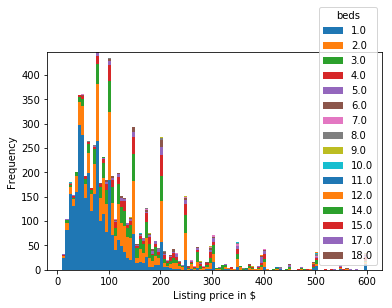

In [38]:
listings.loc[(listings.price <= 600) & (listings.price > 0)].pivot(columns = 'beds',values = 'price').plot.hist(stacked = True,bins=100)
plt.xlabel('Listing price in $');



Vast majority of the listings have one bed, the one-bed listing prices have a wide range. There are listings that have no bed.

## Collinearity

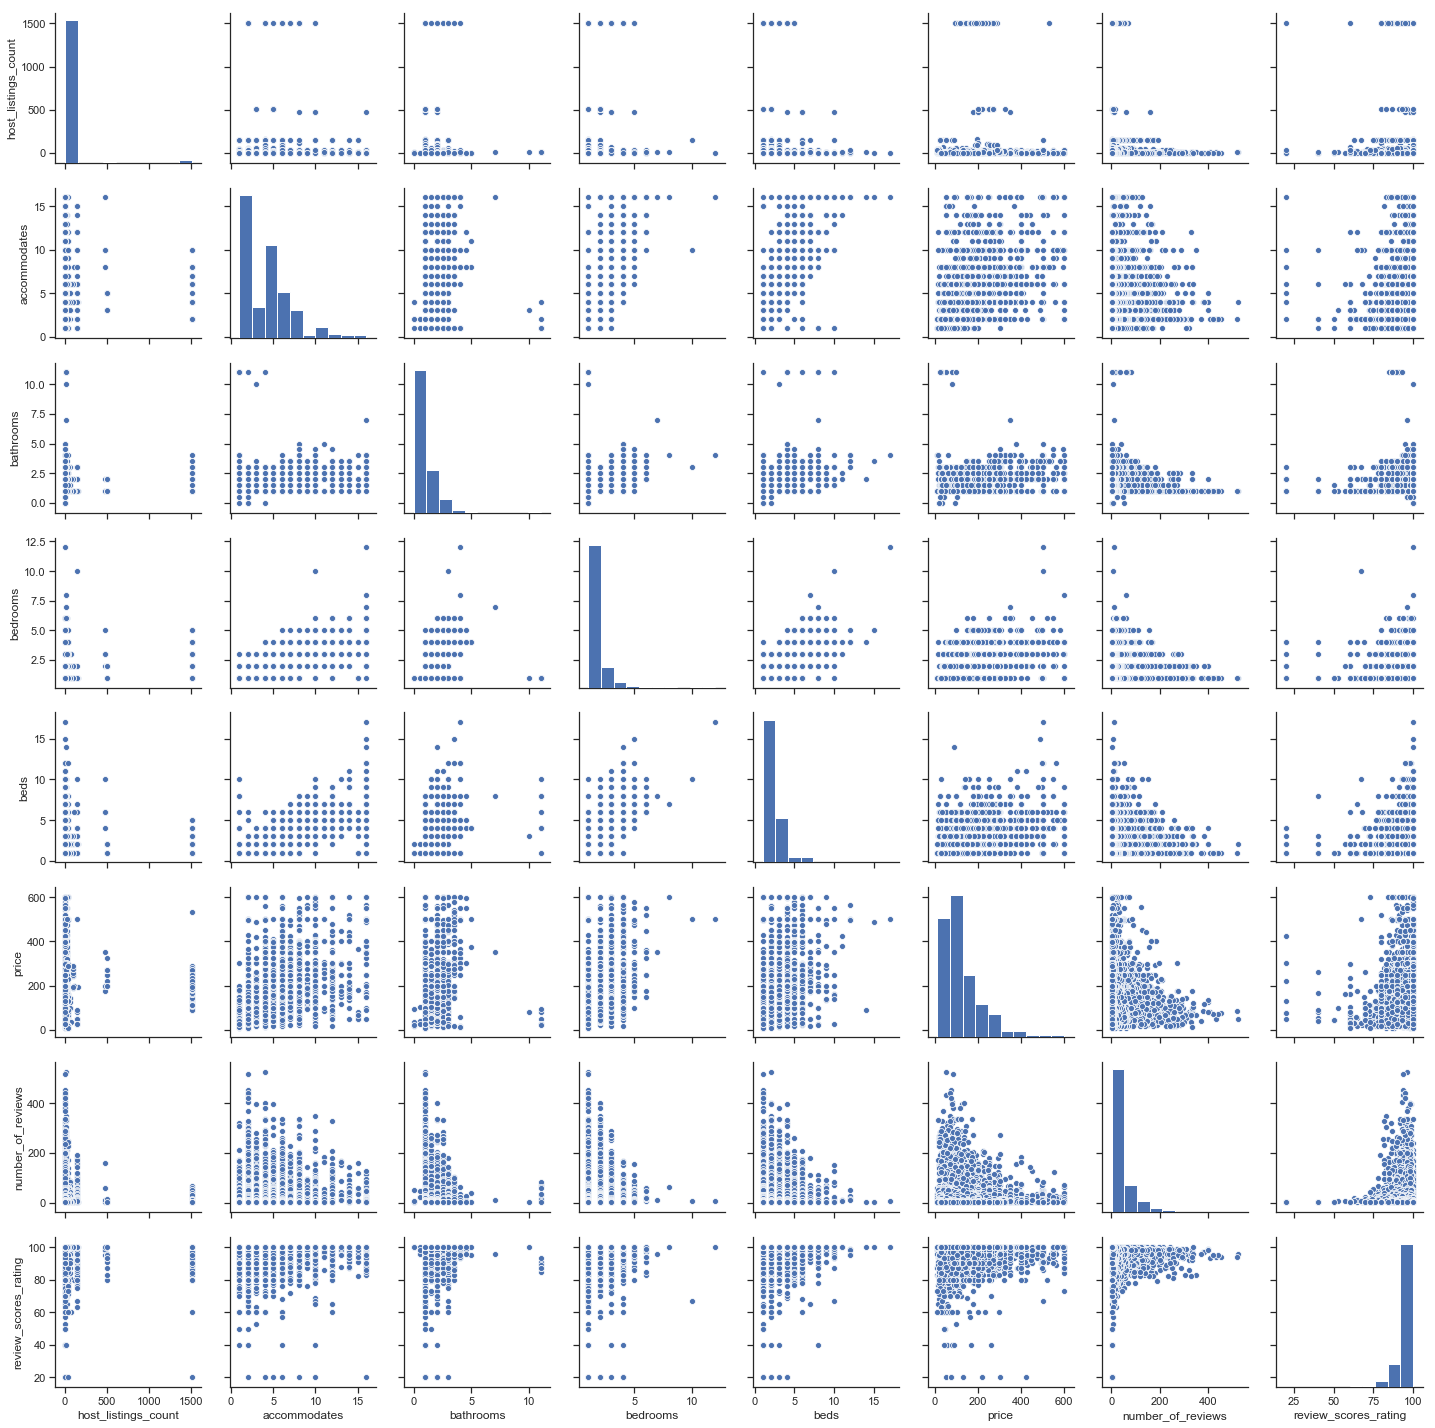

In [39]:
col = ['host_listings_count', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'number_of_reviews', 'review_scores_rating']
sns.set(style="ticks", color_codes=True)
sns.pairplot(listings.loc[(listings.price <= 600) & (listings.price > 0)][col].dropna())
plt.show();

We can see from the output of scatter_matrix that no features show any obvious problems. The most closely related features appear to be 'beds' and 'accommodates'. More beds a unit has, the more it accommodates for sleeping, but even these are only loosely related and the result is far from a straight line. Presumably this is because of different bed sizes, sleeping arrangements, and layout of the rental unit.


# Modeling Lising Prices

## Data preprocessing and feature engineering

In [40]:
listings = listings.loc[(listings.price <= 500) & (listings.price > 0)]

In [41]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer =  CountVectorizer(tokenizer=lambda x: x.split(','))
amenities = count_vectorizer.fit_transform(listings['amenities'])
df_amenities = pd.DataFrame(amenities.toarray(), columns=count_vectorizer.get_feature_names())
df_amenities = df_amenities.drop('',1)

Replace the values in the following feature to 0 if "f", to 1 if "t".

In [42]:
columns =  ['host_is_superhost', 'host_identity_verified', 'host_has_profile_pic',
                   'is_location_exact', 'requires_license', 'instant_bookable',
                   'require_guest_profile_picture', 'require_guest_phone_verification']
for c in columns:
    listings[c] = listings[c].replace('f',0,regex=True)
    listings[c] = listings[c].replace('t',1,regex=True)

Clean up the other money value columns.

In [43]:
listings['security_deposit'] = listings['security_deposit'].fillna(value=0)
listings['security_deposit'] = listings['security_deposit'].replace( '[\$,)]','', regex=True ).astype(float)
listings['cleaning_fee'] = listings['cleaning_fee'].fillna(value=0)
listings['cleaning_fee'] = listings['cleaning_fee'].replace( '[\$,)]','', regex=True ).astype(float)

The following are the numeric features we will be using.

In [44]:
listings_new = listings[['host_is_superhost', 'host_identity_verified', 'host_has_profile_pic','is_location_exact', 
                         'requires_license', 'instant_bookable', 'require_guest_profile_picture', 
                         'require_guest_phone_verification', 'security_deposit', 'cleaning_fee', 
                         'host_listings_count', 'host_total_listings_count', 'minimum_nights',
                     'bathrooms', 'bedrooms', 'guests_included', 'number_of_reviews','review_scores_rating', 'price']]

Fill the missing values in the numeric features with median.

In [45]:
for col in listings_new.columns[listings_new.isnull().any()]:
    print(col)

review_scores_rating


In [46]:
for col in listings_new.columns[listings_new.isnull().any()]:
    listings_new[col] = listings_new[col].fillna(listings_new[col].median())

/Users/yzw/anaconda/envs/p36workshop/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Processing Categorical features

In [47]:
for cat_feature in ['zipcode', 'property_type', 'room_type', 'cancellation_policy', 'neighbourhood_cleansed', 'bed_type']:
    listings_new = pd.concat([listings_new, pd.get_dummies(listings[cat_feature])], axis=1)

Adding amenities feature

In [48]:
listings_new = pd.concat([listings_new, df_amenities], axis=1, join='inner')

Data preprocessing and feature engineering finished.

## Random Forest Regressor

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

y = listings_new['price']
x = listings_new.drop('price', axis =1)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=1)
rf = RandomForestRegressor(n_estimators=500, 
                               criterion='mse', 
                               random_state=3, 
                               n_jobs=-1)
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
rmse_rf= (mean_squared_error(y_test,y_test_pred))**(1/2)

print('RMSE test: %.3f' % rmse_rf)
print('R^2 test: %.3f' % (r2_score(y_test, y_test_pred)))

RMSE test: 54.298
R^2 test: 0.609


### Determine Performance Metrics

To put our predictions in perspective, we can calculate an accuracy using the mean average percentage error subtracted from 100 %.

In [50]:

# Calculate the absolute errors
errors = abs(y_test_pred - y_test)

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')


Accuracy: 65.94 %.


This doesn't look that good. Our model only has 66% accuracy in predicting the listing price.

### Feature importance of Random Forest

In [51]:
coefs_df = pd.DataFrame()

coefs_df['est_int'] = X_train.columns
coefs_df['coefs'] = rf.feature_importances_
coefs_df.sort_values('coefs', ascending=False).head(20)

,est_int,coefs
14,bedrooms,0.178186
106,Entire home/apt,0.139634
13,bathrooms,0.130325
9,cleaning_fee,0.060598
16,number_of_reviews,0.034579
85,Boutique hotel,0.024095
10,host_listings_count,0.022746
11,host_total_listings_count,0.022356
17,review_scores_rating,0.018825
8,security_deposit,0.014071


At the top of the list is bedrooms, which indicates the number of bedrooms. This tells us the best predictor of the listing price is bedrooms, a rather intuitive finding. The second most important factor is the Entire home/apt, also not that surprising. Bathrooms, along with cleaning_fee, number of reviews turn out to be very helpful. These importances all make sense as we would expect them to be predictors of price.

## Conclusion

The feature importance produced by this model is close to my presumptions.
The results we achieved is 54.298 for RMSE, and the model explains 60.9% of the variability in listing price. And we don't get a good accuracy from our results.
But we know this is far from enough.
This is not a satisfying result as we should use more models like regressions to evaluate. And we can tell that price is not that easy to model. We might need more features to give us explicit signs. We may want to add features like seasonality, length of stay and so on. 